# Exploring Fires

## Notes

A lot of this info taken from: https://www.earthdata.nasa.gov/faq/firms-faq

### Images vs ImageCollections in GEE

### Smoke and Cloud Cover in Imagery

### MODIS vs VIIRS reso
![title](images/MODIS.png)
![title](images/VIIRS.png)

### Different Data Sources 

#### Hot spots ("Active fire detections") (Sensor/Platform):
- Can be pulled from GEE or FIRMS
- **MODIS/(Terra, Aqua)**: 1 km, Global
- **VIIRS/(Suomi NPP, NOAA-20, NOAA-21)**: 375 m, Global, the orbit of NOAA-21 is about 50 minutes ahead of NOAA-20 with Soumi NPP orbiting between them
- **OLI/(Landsat 8 & 9)**: 30 m, US-Canada
- **ABI/(GOES-16 & 18)**: 2 km sub-satellite, Americas
- **SEVIRI/(Meteosat 9 & 11)**: 2 km sub-satellite, Europe-Africa-India
- **AHI/(Himawari-8)**: 2 km sub-satellite, Australia/Asia

#### Fire Perimeters Canada: 
- **NBAC** (polygons): https://cwfis.cfs.nrcan.gc.ca/datamart/metadata/nbac
    - NBAC stands for the National Burned Area Composite, calculates the area of forest burned on a national scale for each year since 1972 (currently up to 2024-05-30)
    - Created using Sentinel & Landsat data 
- **NFDB** (point and polygons): https://cwfis.cfs.nrcan.gc.ca/datamart/metadata/nfdbpoly, https://cwfis.cfs.nrcan.gc.ca/ha/nfdb?type=pnt&year=9999
    - NFDB stands for National Fire Database
    - the polygon data only goes to 2021, so we'll use the point data which goes to 2023

From ChatGPT:

In Canada, the **National Burned Area Composite (NBAC)** and the **National Fire Database (NFD)** serve different purposes in wildfire management and research.

1. **National Burned Area Composite (NBAC)**:
   - This is a satellite-based product that provides information on the areas burned by wildfires. 
   - It typically offers updated maps and data about burned regions, helping to assess the extent and severity of fire impacts.
   - The NBAC is useful for monitoring and reporting on recent fires, as well as for planning recovery efforts.

2. **National Fire Database (NFD)**:
   - This is a comprehensive database that collects information about wildfires across Canada, including details such as fire causes, sizes, locations, and response actions.
   - The NFD serves as a historical record and supports analysis of fire trends over time.
   - It is often used for research, policy development, and fire management planning.

In summary, the NBAC focuses on providing real-time and satellite-derived information about burned areas, while the NFD offers a broader historical perspective on fire incidents across Canada.

#### Canadian Fire Spread Dataset: 
- **CFSDS**: https://osf.io/f48ry/
   - an event-based fire growth database built on the combination of high-precision fire event boundaries and multi-sensor active fire detections

#### SP vs. URT/NRT/RT
- Standard data are internally consistent, well-calibrated record 
- URT (ultra real-time), RT (real-time), AND NRT (near real-time) are made more quickly than standard processing to support environmental monitoring, response to hazard/disaster events, etc.
- NRT provide data within 1-3 hours of satellite overpass
- RT and URT are predicted on raw satellite data collected via direct readout ground stations



## Questions

1. How are the fire perimeters made? NBAC is assumed to be the most consistent fire perimeters and this is made using Landsat & Sentinel, but what about hotspots predicted using different tools on different satellites? Ex. VIIRS & MODIS - the tools on these satellites then aren't used to create the fire perimeters, so comparing these hotspots seems a bit odd if they weren't created using the same tools 

# Loading Imagery with GEE

In [114]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from cartopy import crs as ccrs
from geodatasets import get_path

from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

ee.Authenticate()
ee.Initialize(project='karlzam')

In [115]:
startDate = '2023-09-22'
endDate = '2023-10-24'

In [116]:
Map = geemap.Map()

# Large scale international boundary polygons, simplified
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

# Using swaziland as an example because it's small
roi = countries.filter(ee.Filter.eq("country_na", "Canada"));

# Get map
Map.addLayer(roi, {}, "Canada")

# Center the object at the region of interest with a zoom of 8
Map.centerObject(roi,4)

# Load in landsat data with filter
# Originally this covers the entire world over a long time series 
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(startDate, endDate).filterBounds(roi)

# Remove clouds
composite = ee.Algorithms.Landsat.simpleComposite(**{
    'collection': landsat,
    'asFloat': True
})

# Define landsat bands we'll be using 
rgbVis = {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':0.3}

Map.addLayer(composite.clip(roi), rgbVis, "Landsat RGB")

In [117]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(startDate, endDate)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

Map.add_layer(dataset.mean(), visualization, 'RGB-Sentinel')

In [118]:
# FIRMS
# MODIS fire thermal anomalies 
# Active fire locations 

burned_areas_FIRMS = ee.ImageCollection("FIRMS").filterDate(startDate, endDate)
fires = burned_areas_FIRMS.select('T21')

firesVis = {'min': 0, 'max': 500.0, 'palette': ['red', 'orange', 'yellow']}

Map.addLayer(fires, firesVis, "FIRMS")

In [119]:
# Adds MODIS Burned Area
# Monthly per pixel burned area and quality info (500m)

burned_areas_MODIS = ee.ImageCollection("MODIS/061/MCD64A1").filterDate(startDate, endDate)
burnedAreaMODIS = burned_areas_MODIS.select('BurnDate')
burnedAreaVis = {
  'min': 30.0,
  'max': 341.0,
  'palette': ['4e0400', '951003', 'c61503', 'ff1901'],
}
Map.addLayer(burnedAreaMODIS, burnedAreaVis, 'MODIS')

In [120]:
# Launch map
Map

Map(center=[60.558438200875784, -96.70702570923024], controls=(WidgetControl(options=['position', 'transparent…

# Exploring Sources

## Get province polygons

In [121]:
# Province polygons from natural earth data 
# Subset so it's only Alberta, BC, and Sask (arbitrary bc this is where I've extracted some FIRMS data for exploration)
shp_map = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\Natural-Earth\ne_10m_admin_1_states_provinces.shp')
ab_bc_ma_map = map[(shp_map['name']=='Alberta') | (shp_map['name']=='British Columbia') | (shp_map['name']=='Saskatchewan')]
ab_bc_ma_map.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
1236,Admin-1 states provinces,2,CAN-633,633,CA-BC,http://en.wikipedia.org/wiki/British_Columbia,CA,3,British Columbia,Colombie britannique|New Caledonia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-117.03815 48.99251, -117.1580..."
1239,Admin-1 states provinces,2,CAN-632,632,CA-AB,http://en.wikipedia.org/wiki/Alberta,CA,1,Alberta,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-109.99932 48.99262, -110.1241 48.99..."
1240,Admin-1 states provinces,2,CAN-631,631,CA-SK,http://en.wikipedia.org/wiki/Saskatchewan,CA,1,Saskatchewan,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-104.04757 48.99262, -104.18924 48.9..."


## Persistent Hot Spots
These are known hotspots that commonly trigger false positives in fire detection 

In [122]:
# Get persistent hot spots (these are from Piyush)
persistent_hs = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\persistent_heat_sources\m3mask5_lcc.shp')
persistent_hs_sub = persistent_hs[(persistent_hs['prov']=='AB') | (persistent_hs['prov']=='BC') | (persistent_hs['prov']=='SK')]
persistent_hs_sub = persistent_hs_sub.to_crs(epsg=4326)

## Firms Data
This is the alternative method of extracting FIRMS data other than using GEE

Extracted for a somewhat random region containing some of BC, all of AB, and some of MB

Links to google collab tutorials: 
- API: https://colab.research.google.com/drive/1TRxYja1d7pbZOq0aKx2SZJAw_aF-RCZ9
- Viz: https://colab.research.google.com/drive/1YDAktkP41_bpvJIcx5Rg1GF0tx22XnfQ
- Data: https://colab.research.google.com/drive/1LMKJ4Y_8fk4UBNeeUS_1QV5aaFGjQq7J

In [123]:
MAP_KEY = 'e865c77bb60984ab516517cd4cdadea0'
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

transaction_limit             5000
current_transactions             0
transaction_interval    10 minutes
dtype: object

In [124]:
path = get_path("naturalearth.land")
world = gpd.read_file(path)

In [125]:
# VIIRS_NOAA20_NRT
area_url_NOAA20 = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_NOAA20_NRT/-125.6,48.9,-103,60.1/1/2023-09-23'
df_NOAA20 = pd.read_csv(area_url_NOAA20)
gdf_NOAA20 = gpd.GeoDataFrame(
    df_NOAA20, geometry=gpd.points_from_xy(df_NOAA20.longitude, df_NOAA20.latitude), crs="EPSG:4326"
)
gdf_NOAA20.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
0,58.18467,-103.05048,297.48,0.44,0.63,2023-09-23,756,N20,VIIRS,n,2.0NRT,282.61,1.47,N,POINT (-103.05048 58.18467)
1,58.28116,-104.21061,301.68,0.49,0.65,2023-09-23,756,N20,VIIRS,n,2.0NRT,280.74,0.94,N,POINT (-104.21061 58.28116)
2,58.29360,-104.15102,296.12,0.49,0.65,2023-09-23,756,N20,VIIRS,n,2.0NRT,279.39,2.52,N,POINT (-104.15102 58.2936)


In [135]:
# S-NPP & NOAA-20 
# There's standard processing and NRT, but NRT was only available for 2024 so using NRT
area_url_SNPP = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_SNPP_SP/-125.6,48.9,-103,60.1/1/2023-09-23'
df_SNPP = pd.read_csv(area_url_SNPP)
gdf_SNPP = gpd.GeoDataFrame(
    df_SNPP, geometry=gpd.points_from_xy(df_SNPP.longitude, df_SNPP.latitude), crs="EPSG:4326"
)
gdf_SNPP.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,58.18359,-103.04836,316.95,0.48,0.40,2023-09-23,847,N,VIIRS,n,2,283.80,2.48,N,0,POINT (-103.04836 58.18359)
1,58.22665,-121.76677,300.05,0.72,0.76,2023-09-23,847,N,VIIRS,n,2,281.87,5.35,N,0,POINT (-121.76677 58.22665)
2,58.22910,-121.71581,295.78,0.72,0.76,2023-09-23,847,N,VIIRS,n,2,283.09,2.08,N,0,POINT (-121.71581 58.2291)


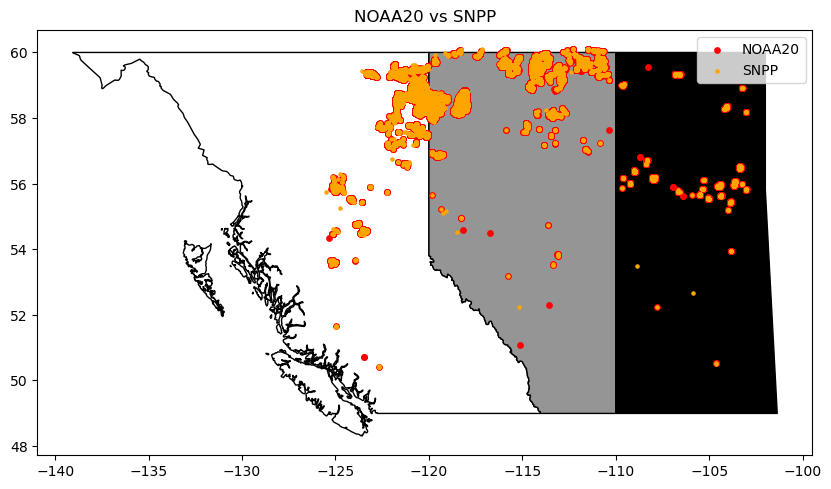

In [141]:
fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_NOAA20.plot(ax=ax, color='red', markersize=15, label='NOAA20')
gdf_SNPP.plot(ax=ax, color='orange', markersize=5, label='SNPP')
plt.title('NOAA20 vs SNPP')
plt.legend()

## NBAC

In [126]:
NBAC = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\NBAC\nbac_1972_2023_20240530.shp')
NBAC = NBAC.to_crs(epsg=4326)
NBAC.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,geometry
0,2022.0,439.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/06/28,2022/10/02,2022/06/26,0000/00/00,2022/09/16,45023.957801,45023.957801,None,AB,None,None,20240530,2022_439,"MULTIPOLYGON (((-111.2759 58.9938, -111.27537 ..."
1,2022.0,74.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/07/07,2022/07/08,2022/07/08,2022/07/18,2022/09/08,737.755249,737.755249,None,NT,None,None,20240530,2022_74,"MULTIPOLYGON (((-105.28649 60.29694, -105.2863..."
2,2022.0,149.0,MAFiMS,Landsat,Processed imagery,Natural,2022/07/08,2022/08/26,2022/06/21,2022/11/03,2022/10/22,9572.430492,9572.430492,None,NT,None,None,20240530,2022_149,"MULTIPOLYGON (((-122.17543 61.9815, -122.17572..."
3,2022.0,156.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2022/08/17,2022/10/03,2022/08/18,2022/10/27,2022/10/17,26761.761894,26761.761894,None,NT,None,None,20240530,2022_156,"MULTIPOLYGON (((-111.28776 60.15918, -111.2875..."
4,2022.0,281.0,MAFiMS,Sentinel-2,Processed imagery,Undetermined,2022/07/04,2022/07/07,0000/00/00,0000/00/00,2022/08/23,400.728797,400.728797,None,YT,None,None,20240530,2022_281,"MULTIPOLYGON (((-135.40711 63.96983, -135.4071..."


In [127]:
NBAC['YEAR'].unique()

array([2022., 1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979.,
       1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2018., 2019., 2020., 2021., 2023.])

In [128]:
# Let's chop this down to just 2023
NBAC_23 = NBAC[NBAC['YEAR']==2023.0]
NBAC_23.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,geometry
46740,2023.0,217.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/07/12,2023/08/25,2023/06/29,0000/00/00,2023/09/30,43522.445118,43522.445118,None,NT,None,None,20240530,2023_217,"MULTIPOLYGON (((-113.94436 62.73676, -113.9443..."
46741,2023.0,337.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/06/29,2023/09/20,2023/06/29,2023/09/06,2023/09/16,17565.255407,17565.255407,None,NT,None,None,20240530,2023_337,"MULTIPOLYGON (((-125.86883 64.16122, -125.8688..."
46742,2023.0,690.0,MAFiMS,Sentinel-2,Processed imagery,Undetermined,2023/06/10,2023/09/24,0000/00/00,0000/00/00,2023/10/08,3429.823905,3429.823905,None,AB,None,None,20240530,2023_690,"MULTIPOLYGON (((-114.85002 57.52102, -114.8498..."
46743,2023.0,216.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2023/06/09,2023/07/22,2023/06/05,2023/09/01,2023/09/15,1130.420703,1130.420703,None,NT,None,None,20240530,2023_216,"MULTIPOLYGON (((-121.16414 61.14514, -121.1646..."
46744,2023.0,654.0,MAFiMS,Landsat,Processed imagery,Natural,2023/07/26,2023/07/30,2023/07/26,2023/08/06,2023/08/15,3929.060214,3929.060214,None,SK,None,None,20240530,2023_654,"MULTIPOLYGON (((-107.32076 58.99124, -107.3207..."


<Axes: >

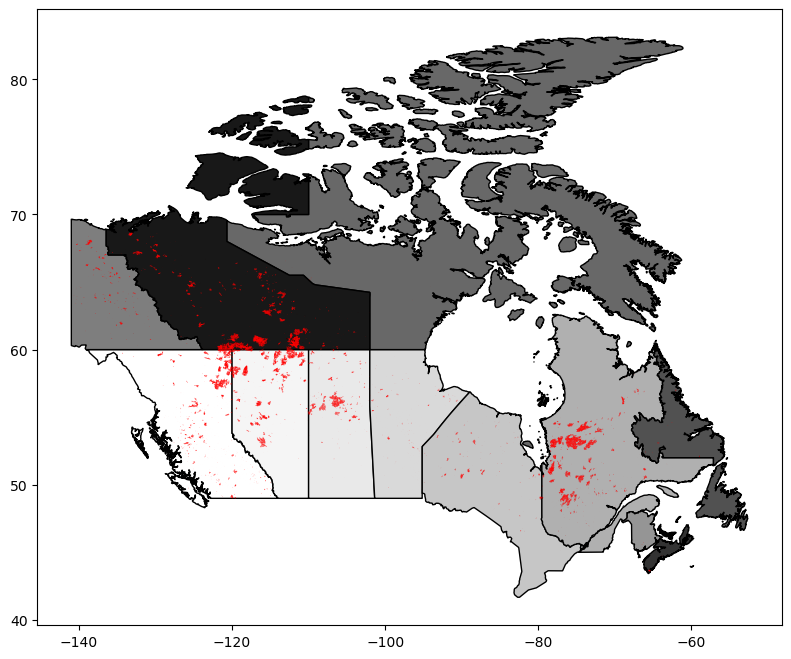

In [129]:
# Plot the NBAC polygons
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad = shp_map[shp_map['iso_a2']=='CA']
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
NBAC_23.plot(ax=ax, linewidth=10, color='red')

In [130]:
# In QGIS I randomly picked a large polygon to look at in more detail as some hotspots were located outside of it 
# In order to account for the fact that hotspots are usually placed in the middle of a fire pixel, not at the exact location due to the resolution of the satellite, we add a 5 km buffer to the existing polygon to allow for some deviation in the placement
# The buffer takes a while to compute so save it once it's done and read it in instead of running again 

#subset_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\subset-poly-2.shp')
#gdf_projected = subset_poly.to_crs(CRS(32610))
#buffer_distance = 5000  # 5 km in meters
#gdf_buffered = gdf_projected.copy()
#gdf_buffered['geometry'] = gdf_projected.buffer(buffer_distance)
#gdf_buffered = gdf_buffered.to_crs(epsg=4326)
#gdf_buffered.to_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')

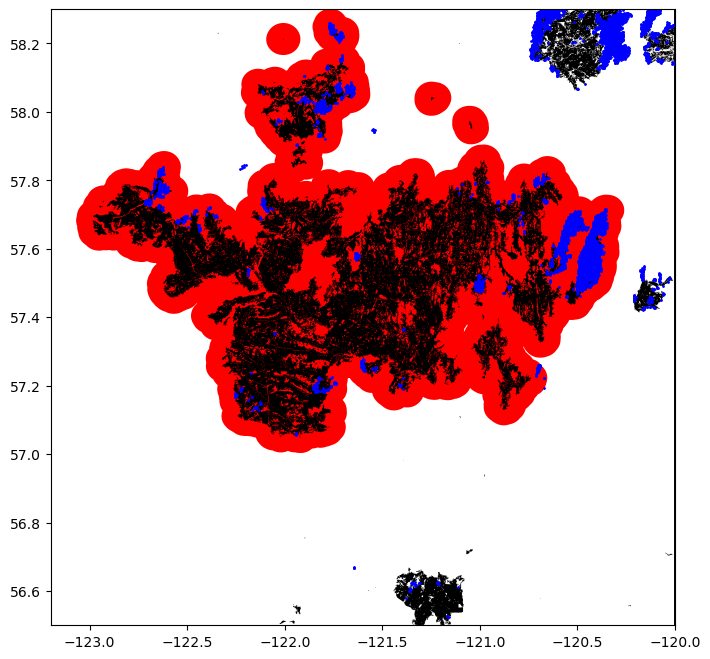

In [131]:
# There are two hotspots here unaccounted for in the buffered NBAC data 

buffer_poly = gpd.read_file(r'C:\Users\kzammit\Documents\Sept23-Fire\buffer-polygon-2.shp')

fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_buffered.plot(ax=ax, linewidth=10, color='red')
NBAC_23.plot(ax=ax, linewidth=10, color='black')
gdf_NOAA20.plot(ax=ax, color="blue", markersize=1)
#plt.legend()
plt.ylim((56.5, 58.3))
plt.xlim((-123.2, -120))
plt.show()

## NFDB

In [132]:
# Not continuing with this data source for now as it only goes up to 2021
NFDB = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\CWFIS-NFDB\NFDB_poly_20210707.shp')
NFDB = NFDB.to_crs(epsg=4326)
NFDB.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,YEAR,MONTH,DAY,REP_DATE,DATE_TYPE,OUT_DATE,DECADE,...,UNBURN_REM,MORE_INFO,POLY_DATE,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,AG_SRCFILE,ACQ_DATE,SRC_AGY2,geometry
0,BC,2004-C10175,None,2004,6,23,2004/06/23,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C10175,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-124.6106 53.08084 0, -124.6099 53..."
1,BC,2004-C10176,None,2004,6,23,2004/06/23,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C10176,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-124.48262 53.06162 0, -124.4815 5..."
2,BC,2004-C50114,None,2004,6,20,2004/06/20,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50114,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-125.1276 52.13023 0, -125.12726 5..."
3,BC,2004-C50125,None,2004,6,21,2004/06/21,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50125,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-125.75419 52.27968 0, -125.75294 ..."
4,BC,2004-C50149,None,2004,6,22,2004/06/22,Report date,0000/00/00,2000-2009,...,None,None,2007/05/17,BC-2004-C50149,None,None,H_FIRE_PLY,2011/06/10,BC,"POLYGON Z ((-126.26477 52.9988 0, -126.26379 5..."


In [133]:
NFDB_point = gpd.read_file(r'C:\Users\kzammit\Documents\Shapefiles\CWFIS-NFDB\NFDB_point_20240613.shp')
NFDB_point_23 = NFDB_point[NFDB_point['YEAR']==2023]
NFDB_sep_23 = NFDB_point_23[NFDB_point_23['MONTH']==9]
#NFDB_sep_23 = NFDB_sep_23[NFDB_sep_23['DAY']==23]
NFDB_sep_23 = NFDB_sep_23.to_crs(epsg=4326)
NFDB_sep_23.head()

,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,...,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,geometry
0,BC-2023-2023-C23369,BC,None,2023-C23369,C23369,51.8197,-122.0729,2023,9,27,...,H,Fire,FUL,None,None,NE of Alkali Creek,None,None,2024/05/06,POINT Z (-122.07285 51.81973 0)
15,BC-2023-2023-V63320,BC,None,2023-V63320,V63320,48.6657,-123.8027,2023,9,19,...,H,Fire,FUL,None,None,Wild Deer Crk,None,None,2024/05/06,POINT Z (-123.80272 48.66572 0)
16,BC-2023-2023-R23312,BC,None,2023-R23312,R23312,53.9193,-126.7468,2023,9,15,...,H,Fire,MON,None,None,3.7km NW of Shelford Hill,None,None,2024/05/06,POINT Z (-126.74678 53.91925 0)
17,BC-2023-2023-G63267,BC,None,2023-G63267,16km Finlay FSR,55.1504,-123.2007,2023,9,15,...,H,Fire,MOD,None,None,16km on the Finley FSR,None,None,2024/05/06,POINT Z (-123.20068 55.15043 0)
25,BC-2023-2023-V53204,BC,None,2023-V53204,BREM RIVER,50.5177,-124.5693,2023,9,9,...,H,Fire,MOD,None,None,Brem River,None,None,2024/05/06,POINT Z (-124.5693 50.5177 0)


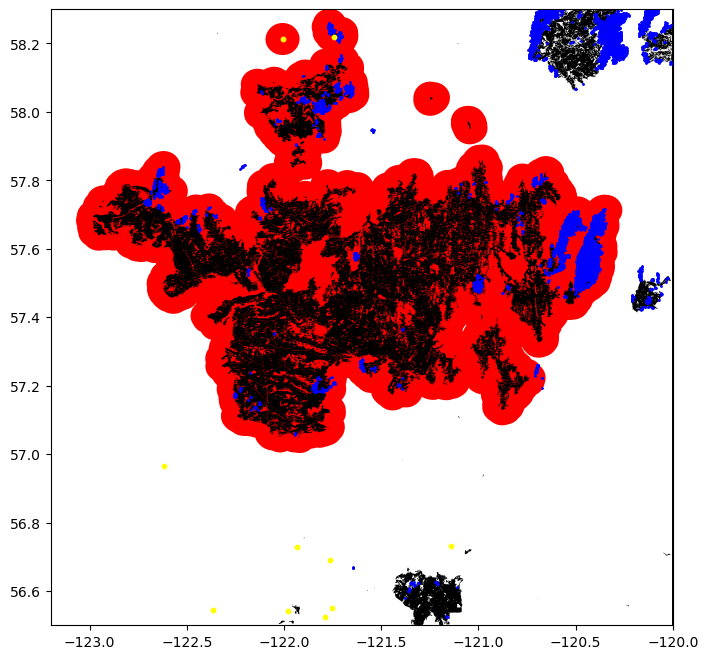

In [134]:
fig, ax = plt.subplots(figsize=(10,8))
ab_bc_ma_map.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_buffered.plot(ax=ax, linewidth=10, color='red')
NBAC_23.plot(ax=ax, linewidth=10, color='black')
gdf_NOAA20.plot(ax=ax, color="blue", markersize=1)
NFDB_sep_23.plot(ax=ax, color="yellow", markersize=10)
#plt.legend()
plt.ylim((56.5, 58.3))
plt.xlim((-123.2, -120))
plt.show()

Hmmmm ok so the NFDB doesn't plot any fires on Sep 23 - but this could be because the "date" isn't the date it was burning on but rather the date it started on. Complicated! I'll try plotting all of september instead. Veryyy interesting, so NFDB singular points do not agree with FIRMS hotspots from NOAA20

## CFSDS

This dataset only goes to 2021 so just for reference

### Point Data

In [143]:
df_CFSDS = pd.read_csv(r'C:\Users\kzammit\Documents\Shapefiles\CFSDS\Firegrowth_pts_v1_01_2021.csv')
gdf_CFSDS = gpd.GeoDataFrame(
    df_CFSDS, geometry=gpd.points_from_xy(df_CFSDS.lon, df_CFSDS.lat), crs="EPSG:4326"
)
gdf_CFSDS.head(3)

,Unnamed: 0,ID,DOB,year,fireday,firearea,ecozone,fwi,isi,ffmc,...,dem,slope,twi,aspect,cumuarea,pctgrowth,prevgrow,sprdistm,lon,lat
0,1,2021_1043,194,2021,2,2660.04,6,14.337202,4.463962,86.914581,...,268.722229,2.855311,5.320358,45.590019,2938.68,954.651163,278.64,4233.349143,-100.234008,55.836818
1,2,2021_1043,194,2021,2,2660.04,6,14.337202,4.463962,86.914581,...,275.638885,1.630800,4.905448,284.972870,2938.68,954.651163,278.64,4233.349143,-100.236691,55.835036
2,3,2021_1043,194,2021,2,2660.04,6,14.337202,4.463962,86.914581,...,275.361115,4.042511,5.142117,351.848633,2938.68,954.651163,278.64,4233.349143,-100.233767,55.835172
3,4,2021_1043,194,2021,2,2660.04,6,14.337202,4.463962,86.914581,...,265.333344,3.000842,5.068369,299.402405,2938.68,954.651163,278.64,4233.349143,-100.236449,55.833391
4,5,2021_1043,194,2021,2,2660.04,6,14.337202,4.463962,86.914581,...,293.722229,7.105934,4.524351,311.759949,2938.68,954.651163,278.64,4233.349143,-100.233526,55.833527


<Axes: >

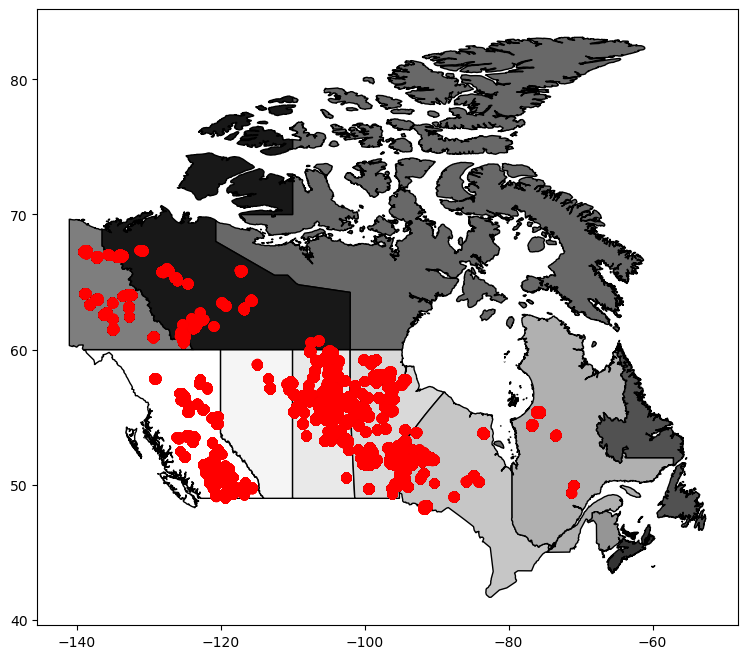

In [146]:
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
gdf_CFSDS.plot(ax=ax, linewidth=1, color='red')

### Tif Data

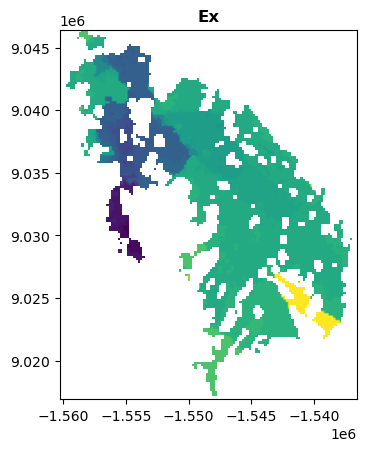

<Axes: title={'center': 'Ex'}>

In [157]:
import rasterio
import rasterio.plot

data_name = r"C:\Users\kzammit\Documents\Shapefiles\CFSDS\2021_33\2021_33_krig.tif"
tiff = rasterio.open(data_name)
rasterio.plot.show(tiff, title = "Ex")

In [150]:
import rioxarray

rds = rioxarray.open_rasterio(data_name)
rds_4326 = rds.rio.reproject("EPSG:4326")
type(rds_4326)

xarray.core.dataarray.DataArray

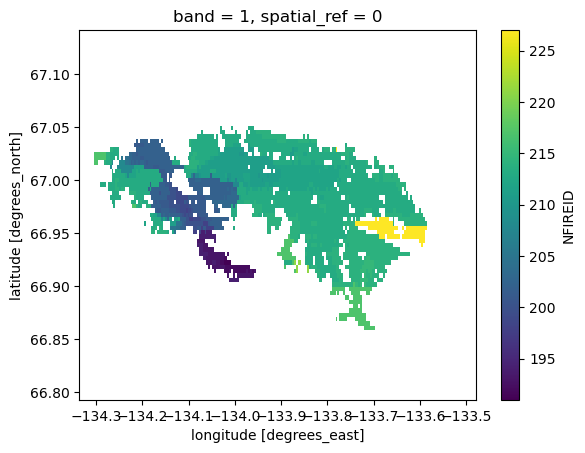

In [151]:
rds_4326.plot()

(-150.0, -50.0)

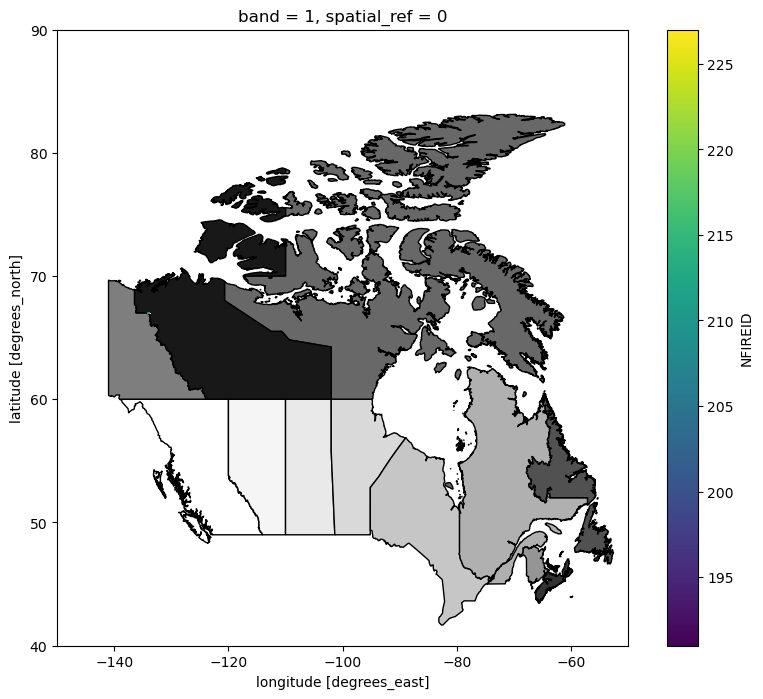

In [156]:
fig, ax = plt.subplots(figsize=(10,8))
shp_map_cad.plot(ax=ax, edgecolor='black', linewidth=1, cmap='Greys')
rds_4326.plot(ax=ax, linewidth=1)
plt.ylim((40, 90))
plt.xlim((-150, -50))